## 迁移学习
将MobileNet网络迁移到猫和狗的图片分类问题中

In [1]:
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np

## 载入数据
方法与之前相同

In [2]:
base_dir = os.path.join('data', 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [3]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [4]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### 设置图片尺寸
MobileNet网络输入的图片尺寸为224 $\times$ 224

In [5]:
BATCH_SIZE = 64  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 224  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [7]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, 
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


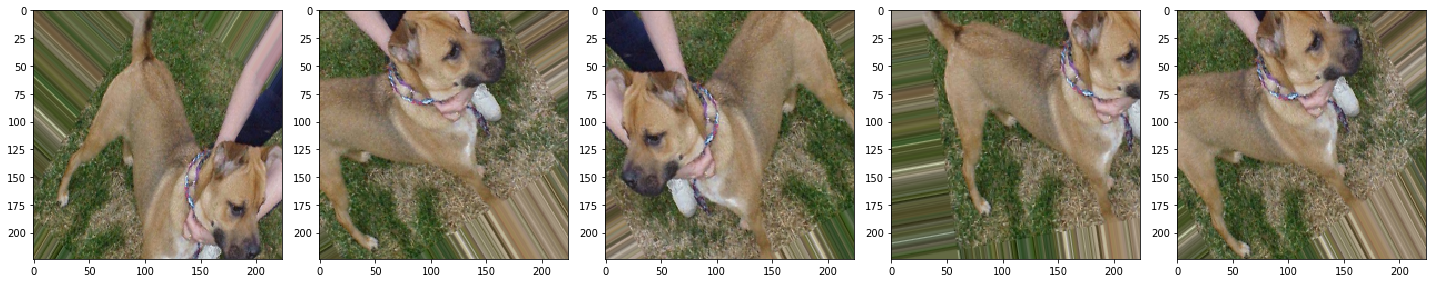

In [8]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [9]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory=validation_dir, 
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## 导入MobileNet
将MobileNet除最后一层外的网络下载到本地，并导入。下载点击[这里](https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/feature_vector/2.tar.gz)。

也可以在线导入，在线导入方法为：
```python
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

feature_extractor.trainable=False

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax')
])
```

不过由于一些原因，在线导入方法不成功。可以通过[修改url](get model.ipynb)将在线导入url改为下载用url。

In [10]:
# 导入MobileNet除最后一层外的网络及参数
feature_extractor = hub.KerasLayer("model/feature_vector/", input_shape=(IMG_SHAPE, IMG_SHAPE, 3))
# 设置不可训练，即参数不会被改变
feature_extractor.trainable=False

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## 编译模型并训练

In [11]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [12]:
EPOCHS=6
history = model.fit_generator(train_data_gen,
                             epochs=EPOCHS,
                             steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                             validation_data=val_data_gen,
                             validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))))

Epoch 1/6


W0726 16:20:10.069681 14024 deprecation.py:323] From C:\Users\arsener\PycharmProjects\tensorflow2.0beta\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


32/32 [==============================] - 171s 5s/step - loss: 0.2882 - accuracy: 0.8800 - val_loss: 0.0813 - val_accuracy: 0.9780
Epoch 2/6
32/32 [==============================] - 161s 5s/step - loss: 0.1151 - accuracy: 0.9555 - val_loss: 0.0640 - val_accuracy: 0.9810
Epoch 3/6
32/32 [==============================] - 159s 5s/step - loss: 0.1037 - accuracy: 0.9575 - val_loss: 0.0541 - val_accuracy: 0.9820
Epoch 4/6
32/32 [==============================] - 162s 5s/step - loss: 0.0880 - accuracy: 0.9650 - val_loss: 0.0519 - val_accuracy: 0.9820
Epoch 5/6
32/32 [==============================] - 161s 5s/step - loss: 0.0737 - accuracy: 0.9675 - val_loss: 0.0469 - val_accuracy: 0.9860
Epoch 6/6
32/32 [==============================] - 160s 5s/step - loss: 0.0844 - accuracy: 0.9660 - val_loss: 0.0483 - val_accuracy: 0.9830


## 可视化训练结果
将模型在训练集以及测试集上分别得到的不同``epoch``对应的``loss``以及准确率进行可视化。

可以看到，在验证集上的准确率可以达到大约97%，与之前相比有相当大的提升。

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

* One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.
* The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

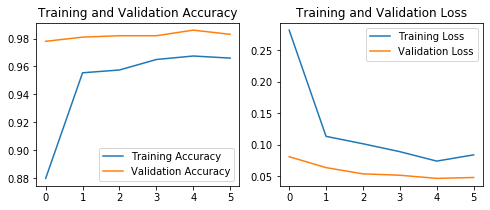

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 保存模型
使用``model.pop()``方法将网络最后一层删除，再用``model.save()``方法将模型保存下来，可供以后使用。

In [20]:
model.pop()
model.save('SavedModelForTest')

In [28]:
model.save('tasdasf.h5py')